https://www.kaggle.com/code/piyas0/image-captioning-with-transformers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
# from torchvision.datasets.mnist import MNIST
from keras.datasets import mnist
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import os
import pandas as pd
from torchvision import datasets, transforms
import shutil
import cv2
from PIL import Image  # Import PIL for conversion
import wandb

2025-05-01 16:15:37.472332: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 16:15:37.479253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746116137.490877     235 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746116137.494395     235 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 16:15:37.506913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

In [2]:
torch.cuda.is_available()

True

In [3]:
device = "cuda"

In [4]:
image_caption_data =  pd.read_csv("/shared-volume/UNATA STORAGE/docker_shared_files/data_root_own_laptop/data/image_text_datasets/flickr-data/captions.txt")

In [5]:
image_caption_data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [6]:
image_caption_data["caption"] = "<|startoftext|> "+ image_caption_data["caption"].str.lower().str.replace('[^\w\s]','') + " <|endoftext|>"

In [7]:
image_path = "/shared-volume/UNATA STORAGE/docker_shared_files/data_root_own_laptop/data/image_text_datasets/flickr-data/images"

In [8]:
# image_caption_data[((image_caption_data["is_image_available"]==True)&(image_caption_data["valid_img_flag"]==False))]

<Axes: >

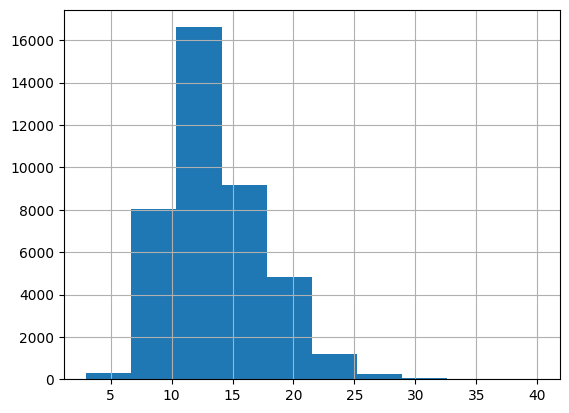

In [9]:
image_caption_data['caption'].str.split().apply(lambda x: len(x)).hist()

In [10]:
image_caption_data['caption'].str.split().explode().value_counts()

caption
a                  62986
<|startoftext|>    40455
<|endoftext|>      40455
.                  36577
in                 18974
                   ...  
devotion               1
nfl                    1
pillared               1
classic-style          1
patterns               1
Name: count, Length: 8920, dtype: int64

In [11]:
image_caption_data_train_val = image_caption_data.sample(frac=0.7)

In [12]:
image_caption_data_train_val.shape # image_caption_data_pred.shape

(28318, 2)

In [13]:
# image_caption_data_train_val = image_caption_data_train_val[image_caption_data_train_val['caption'].str.split().apply(lambda x: len(x)) < 20]

In [14]:
image_caption_data_train_val

,image,caption
23951,3262849619_0bc4f88ef9.jpg,<|startoftext|> a black and white dog with a c...
3470,1765164972_92dac06fa9.jpg,"<|startoftext|> a girl with a nose ring , earr..."
7002,2273799395_5072a5736d.jpg,<|startoftext|> a lady in red gloves on ski 's...
2149,1420060118_aed262d606.jpg,<|startoftext|> a young ninja jumps into the a...
19731,3084011028_d1e2c40d7d.jpg,<|startoftext|> the two women are smiling at t...
...,...,...
25341,3326086533_23a0a54a8e.jpg,<|startoftext|> a black dog is running on the ...
32174,3593220756_5c416c3ceb.jpg,<|startoftext|> this man is wearing a wetsuit ...
6867,2268109835_d6edbe1c2b.jpg,<|startoftext|> a person trying to catch birds...
14978,2813033949_e19fa08805.jpg,<|startoftext|> a white and black dog is playi...


In [15]:
image_caption_data_train_val = image_caption_data_train_val.reset_index(drop=True)

In [16]:
train_index = image_caption_data_train_val.sample(int(len(image_caption_data_train_val)*0.90)).index.tolist()

In [20]:
train_set = image_caption_data_train_val.loc[train_index]
val_set = image_caption_data_train_val.loc[[i for i in image_caption_data_train_val.index if i not in train_index]]

In [21]:
train_set.shape, val_set.shape

((25486, 2), (2832, 2))

In [22]:
train_set = train_set.sample(frac=0.09)
val_set = val_set.sample(frac=0.05)

train_set.shape, val_set.shape

((2294, 2), (142, 2))

In [23]:
len(set(train_set.caption.str.split().explode().tolist()))

2376

In [24]:
del image_caption_data
del image_caption_data_train_val

In [25]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [26]:
language_model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [27]:
tokenizer.eos_token_id

50256

In [28]:
vocab = tokenizer.get_vocab
tokenizer.vocab_size

50257

In [29]:
tokenizer.convert_ids_to_tokens(50256)

'<|endoftext|>'

In [30]:
tokenizer.pad_token = '<|pad|>'
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
language_model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50258, 768)

In [31]:
tokenizer.bos_token = '<|startoftext|>'
tokenizer.add_special_tokens({'bos_token': '<|startoftext|>'})
language_model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [32]:
tokenizer.convert_tokens_to_ids("<|pad|>")

50257

In [33]:
# tokenizer("I am atanu and I love to eat", padding='max_length', return_tensors="pt", truncation=True, max_length=20)

In [34]:
# # 3. Freeze the base parameters
# for parameter in language_model.parameters():
#     parameter.requires_grad = False

In [35]:
# language_model = language_model.to(device)

In [36]:
# language_model.lm_head.weight.requires_grad = True
# language_model.transformer.wte.weight.requires_grad = True  # Optional

In [37]:
# from peft import get_peft_model, LoraConfig, TaskType
# lora_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM,  # Language Modeling
#     inference_mode=False,
#     r=8,  # rank of LoRA
#     lora_alpha=16,
#     lora_dropout=0.1,
#     bias="none",  # don't adapt bias
#     target_modules=["c_attn","lm_head"],  # target GPT-2's attention projection
# )

# # Inject LoRA adapters
# language_model = get_peft_model(language_model, lora_config)
# language_model.print_trainable_parameters()

In [38]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights # requires torchvision >= 0.13, "DEFAULT" means best available

In [39]:
# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16() #<- model saved at /root/.cache/torch/hub/checkpoints/
pretrained_vit.load_state_dict(torch.load("/shared-volume/UNATA STORAGE/docker_shared_files/models/torchvision/vit_b_16-c867db91.pth"))

<All keys matched successfully>

In [40]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [41]:
# pretrained_vit = pretrained_vit.to(device)

In [42]:
# # 3. Freeze the base parameters
# for parameter in pretrained_vit.parameters():
#     parameter.requires_grad = False

In [44]:
pretrained_vit.heads = nn.Linear(in_features=768, out_features=768).to(device)

In [45]:
# pretrained_vit.heads.requires_grad = True

In [46]:
transform_method = pretrained_vit_weights.IMAGENET1K_V1.transforms()
transform_method

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [47]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [48]:
class ImageDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_index = self.data["image"].iloc[idx]
        img = cv2.imread(os.path.join(self.image_path,f"{img_index}"), cv2.IMREAD_COLOR_RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cap = self.data.loc[self.data["image"]==img_index,"caption"].values[0]
        #img = cv2.resize(img, (224, 224))
        #img = img.astype(np.float32) / 255.0  # Normalize in the function
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        #img_transformed = torch.tensor(img).permute(2, 0, 1)  # Convert to [C, H, W]
        return img , cap

In [49]:
train_dataset = ImageDataset(train_set, image_path, transform=transform_method)
val_dataset = ImageDataset(val_set, image_path, transform=transform_method)

In [50]:
torch.manual_seed(2809)
train_dl = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [51]:
t = next(iter(train_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


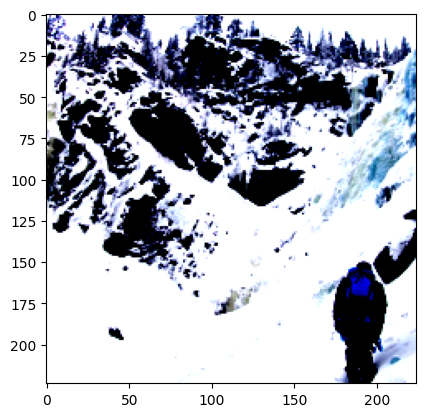

In [52]:
plt.imshow(t[0][0].permute(1,2,0))

In [53]:
class MultiModalProjector(nn.Module):
    def __init__(self, text_embed_dim, image_embed_dim, dropout=0.1):
        super().__init__()

        # Define the projection network
        self.net = nn.Sequential(
            # Linear layer to expand the image embedding dimension
            nn.Linear(image_embed_dim, 4 * image_embed_dim),

            # GELU activation function
            nn.GELU(),

            # Linear layer to project the expanded image embeddings to the text embedding dimension
            nn.Linear(4 * image_embed_dim, text_embed_dim),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pass the input through the projection network
        x = self.net(x)
        return x

In [54]:
language_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

##### Work on the text part

In [55]:
class PretrainedLanguageModel(nn.Module):

    def __init__(self, img_embed_dim, language_model):
        super().__init__()
        #--------------------------------------------------#
        
        self.image_embed_projector = MultiModalProjector(n_embd, img_embed_dim)
        
        self.language_model = language_model
        
        #self.position_embedding_table = nn.Embedding(block_size+1, n_embd) #** Learnable Positional Encoding
        #--------------------------------------------------#
        

    def forward(self, idx, image_embeds=None, targets=None, attention_mask=None):
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.language_model.transformer.wte(idx).to(device)
                
        img_proj_embed = self.image_embed_projector(image_embeds).unsqueeze(1)

        inputs_embeds = torch.cat([tok_emb, img_proj_embed], dim =1)
        
        #### No Softmax needed as cross_entropy function in pytorch internally applies
        #### the softmax before loss calculation
        batch_size = idx.size(0)
        
        # Create attention mask for image token
        if attention_mask is not None:
            attention_mask = torch.cat([torch.ones(batch_size, 1, device=device), attention_mask], dim=1)

        if targets is not None:
            targets = torch.cat([torch.full((batch_size, 1), -100, dtype=torch.long, device=device), targets], dim=1)
        
        output = self.language_model(inputs_embeds=inputs_embeds,
                                     attention_mask=attention_mask,
                                     labels=targets)

        return output

In [56]:
# batch_size= 16
block_size= 20
max_iters= 3000
eval_interval= 100
# learning_rate= 0.0001
eval_iters= 200
n_embd= 768
n_head= 4
n_blocks= 8
dropout= 0.2

In [57]:
vocab_size = tokenizer.vocab_size

In [58]:
vocab_size

50257

In [59]:
language_model.generate()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[50256,   198,   464,   717,   640,   314,  2497,   262,   649,  2196,
           286,   262,   983,    11,   314,   373,   523,  6568,    13,   314]])

In [60]:
class VisionLanguageModel(nn.Module):
    def __init__(self, image_embed_dim, vision_encoder, language_model):
        super().__init__()

        # Set num_hiddens equal to image_embed_dim
        num_hiddens = image_embed_dim

        # Initialize the vision encoder (ViT)
        self.vision_encoder = vision_encoder

        # Initialize the language model decoder (DecoderLanguageModel)
        self.decoder = PretrainedLanguageModel(image_embed_dim, language_model)

    def forward(self, img_array, idx, attention_mask=None, targets=None):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        if targets is not None:
            # If targets are provided, compute the logits and loss
            output = self.decoder(idx, image_embeds, targets, attention_mask)
            return output.logits, output.loss
        else:
            # If targets are not provided, compute only the logits
            output = self.decoder(idx, image_embeds)
            return output.logits

    def generate(self, image_embeds, input_ids, max_new_tokens=20, top_k=50, top_p=0.95):
        """
        image_embeds: (B, img_embed_dim)
        input_ids: (B, T) token ids as prompt (e.g., <BOS>)
        """
        B = image_embeds.size(0)

        # Project and reshape image embedding
        img_token = self.vision_encoder(image_embeds).unsqueeze(1)  # (B, 1, hidden_dim)

        # Embed the text prompt tokens
        prompt_embeds = self.decoder.language_model.transformer.wte(input_ids)  # (B, T, hidden_dim)

        # Concatenate image + prompt tokens
        inputs_embeds = torch.cat([img_token, prompt_embeds], dim=1)

        # Set total max_length = image_token(1) + prompt_len + new_tokens
        total_length = inputs_embeds.size(1) + max_new_tokens

        # Generate using precomputed embeddings
        generated_ids = self.decoder.language_model.generate(
            inputs_embeds=inputs_embeds,
            max_length=total_length,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

        return generated_ids


In [61]:
vlm = VisionLanguageModel(image_embed_dim=768, vision_encoder=pretrained_vit, language_model=language_model).to(device)

In [62]:
for name, param in vlm.named_parameters():
    param.requires_grad = False

In [63]:
for name, param in vlm.named_parameters():
    if param.requires_grad:
        print(f"NO grad flowing for {name}")

In [64]:
language_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [65]:
for name, param in vlm.decoder.image_embed_projector.named_parameters():
    param.requires_grad = True
    
for i in range(11,12):
    for name, param in vlm.decoder.language_model.transformer.h[i].named_parameters():
        param.requires_grad = True

for name, param in vlm.decoder.language_model.transformer.ln_f.named_parameters():
    param.requires_grad = True
    
for name, param in vlm.decoder.language_model.transformer.wte.named_parameters():
    param.requires_grad = True
    
for name, param in vlm.decoder.language_model.transformer.wpe.named_parameters():
    param.requires_grad = True

for name, param in vlm.vision_encoder.heads.named_parameters():
    param.requires_grad = True

In [66]:
for name, param in vlm.named_parameters():
    if param.requires_grad:
        print(f"grad flowing for {name}")

grad flowing for vision_encoder.heads.weight
grad flowing for vision_encoder.heads.bias
grad flowing for decoder.image_embed_projector.net.0.weight
grad flowing for decoder.image_embed_projector.net.0.bias
grad flowing for decoder.image_embed_projector.net.2.weight
grad flowing for decoder.image_embed_projector.net.2.bias
grad flowing for decoder.language_model.transformer.wte.weight
grad flowing for decoder.language_model.transformer.wpe.weight
grad flowing for decoder.language_model.transformer.h.11.ln_1.weight
grad flowing for decoder.language_model.transformer.h.11.ln_1.bias
grad flowing for decoder.language_model.transformer.h.11.attn.c_attn.weight
grad flowing for decoder.language_model.transformer.h.11.attn.c_attn.bias
grad flowing for decoder.language_model.transformer.h.11.attn.c_proj.weight
grad flowing for decoder.language_model.transformer.h.11.attn.c_proj.bias
grad flowing for decoder.language_model.transformer.h.11.ln_2.weight
grad flowing for decoder.language_model.trans

In [67]:
from nltk.translate.bleu_score import sentence_bleu

In [68]:
def get_batch(image_tokens, caps, block_size):
    all_inputs = []
    all_targets = []
    all_image_tokens = []

    for j, caption in enumerate(caps):
        tokens = torch.tensor(tokenizer.encode(caption), dtype=torch.long)
        tokens = tokens[:block_size]  # truncate if needed
        for k in range(1, len(tokens)-1):
            inp = tokens[k:k+block_size]
            tgt = tokens[k+1:k+block_size+1]
            all_inputs.append(inp)
            all_targets.append(tgt)
            all_image_tokens.append(image_tokens[j])  # repeat corresponding image
    

    # Padding
    max_len = max(len(seq) for seq in all_inputs)
    padded_inputs = torch.full((len(all_inputs), max_len), 50257, dtype=torch.long).to(device)
    padded_targets = torch.full((len(all_targets), max_len), 50257, dtype=torch.long).to(device)
    attention_mask = torch.zeros((len(all_inputs), max_len), dtype=torch.long).to(device)
    image_tokens_expanded = torch.stack(all_image_tokens).to(device)

    for i in range(len(all_inputs)):
        padded_inputs[i, :len(all_inputs[i])] = all_inputs[i]
        padded_targets[i, :len(all_targets[i])] = all_targets[i]
        attention_mask[i, :len(all_inputs[i])] = 1 
    return image_tokens_expanded, padded_inputs, padded_targets, attention_mask

In [69]:
# image_tokens_expanded, padded_inputs, padded_targets, attention_mask = get_batch(t[0].to(device), t[1], block_size)

In [70]:
epochs = 3
train_losses = []
valid_losses = []
test_accuracies = []
best_val_loss = 1e9

In [71]:
optim = torch.optim.Adam(vlm.parameters(),lr=3e-3/25, weight_decay=1e-2) #lr = 6e-4 / 25., weight_decay=1e-3
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=1e-3 ,steps_per_epoch=len(train_dl),epochs=epochs)

In [72]:
for ep in tqdm(range(epochs)):
    vlm.train()
    trl = 0.
    tprog = tqdm(enumerate(train_dl), total=len(train_dl))

    for i, (image_tokens, caps) in tprog:
        image_tokens = image_tokens.to(device)
        
        image_tokens_expanded, padded_inputs, padded_targets, attention_mask = get_batch(image_tokens, caps, block_size)

        # Forward & backward pass
        loss = vlm(image_tokens_expanded, padded_inputs, attention_mask, padded_targets)[1]
        
        with torch.autograd.set_detect_anomaly(True):
            loss.backward()

        optim.step()
        optim.zero_grad()
        sched.step()
        trl += loss.item()
        tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl / len(train_dl))

    # Validation loop (same logic)
    vlm.eval()
    all_refs = []
    all_preds = []
    with torch.no_grad():
        vrl = 0.
        bleu_score = 0.
        vprog = tqdm(enumerate(val_dl), total=len(val_dl))
        
        for i, (image_tokens, caps) in vprog:
            image_tokens = image_tokens.to(device)

            image_tokens_expanded, padded_inputs, padded_targets, attention_mask = get_batch(image_tokens, caps, block_size)

            loss = vlm(image_tokens_expanded, padded_inputs, attention_mask, padded_targets)[1]
            vrl += loss.item()
            vprog.set_description(f'valid step loss: {loss.item():.4f}')
            
            prompt = torch.full((image_tokens.shape[0], 1), fill_value=tokenizer.convert_tokens_to_ids('|<startoftext>|'), dtype=torch.long).to(device)
            preds = vlm.generate(image_tokens, prompt, max_new_tokens=20)

            for i in range(len(preds)):
                pred_text = tokenizer.decode(preds[i].tolist())
                ref_text = caps[i]  # Assumes raw string
                all_preds.append(pred_text)
                all_refs.append([ref_text])  # BLEU expects list of refs
            bleu_score += np.mean([sentence_bleu(r, p.split()) for r, p in zip(all_refs, all_preds)])
            
        vloss = vrl / len(val_dl)
        bleu = bleu_score/ len(val_dl)
        
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f} bleu_score: {bleu:.4f}')

train step loss: 7.8607:   8%|█▎              | 96/1147 [00:45<08:24,  2.08it/s]


train step loss: 3.5543:  17%|██▌            | 193/1147 [01:32<07:41,  2.07it/s]


train step loss: 2.3162:  25%|███▊           | 290/1147 [02:22<07:44,  1.85it/s]


train step loss: 1.4633:  34%|█████          | 387/1147 [03:15<07:09,  1.77it/s]


train step loss: 1.1121:  42%|██████▎        | 484/1147 [04:12<06:37,  1.67it/s]


train step loss: 1.2673:  51%|███████▌       | 581/1147 [05:06<05:49,  1.62it/s]


train step loss: 1.7550:  59%|████████▊      | 678/1147 [06:07<05:11,  1.51it/s]


train step loss: 1.8556:  68%|██████████▏    | 775/1147 [07:14<04:45,  1.30it/s]


train step loss: 1.8284:  76%|███████████▍   | 872/1147 [08:22<03:33,  1.29it/s]


train step loss: 2.2483:  84%|████████████▋  | 969/1147 [09:35<02:20,  1.26it/s]


train step loss: 2.8540:  93%|█████████████ | 1066/1147 [10:48<00:57,  1.40it/s]


train step loss: 1.9654: 100%|██████████████| 1147/1147 [11:54<00:00,  1.61it/s]

valid step loss: 1.7890:  21%|███▊              | 15/71 [00:11<00:45,  1.24it/s]


 33%|██████████████▋                             | 1/3 [12:49<25:38, 769.15s/it]

epoch 0 | train_loss: 2.9338 valid_loss: 1.9904 bleu_score: 0.0000



train step loss: 1.8523:   8%|█▎              | 96/1147 [01:17<15:02,  1.17it/s]


train step loss: 1.8668:  17%|██▌            | 193/1147 [02:34<12:13,  1.30it/s]


train step loss: 1.6716:  25%|███▊           | 290/1147 [03:54<12:19,  1.16it/s]


train step loss: 2.4968:  34%|█████          | 387/1147 [05:13<10:17,  1.23it/s]


train step loss: 2.0354:  42%|██████▎        | 484/1147 [06:26<07:53,  1.40it/s]


train step loss: 1.9970:  51%|███████▌       | 581/1147 [07:58<08:26,  1.12it/s]


train step loss: 1.9427:  59%|████████▊      | 678/1147 [09:18<07:43,  1.01it/s]


train step loss: 1.8580:  68%|██████████▏    | 775/1147 [10:37<04:27,  1.39it/s]


train step loss: 1.8444:  76%|███████████▍   | 872/1147 [11:53<02:58,  1.54it/s]


train step loss: 1.6936:  84%|████████████▋  | 969/1147 [13:03<02:02,  1.45it/s]


train step loss: 1.8093:  93%|█████████████ | 1066/1147 [14:08<00:56,  1.44it/s]


train step loss: 1.9682: 100%|██████████████| 1147/1147 [15:04<00:00,  1.27it/s]

valid step loss: 1.8961:   4%|▊                  | 3/71 [00:02<00:47,  1.42it/s]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score ev

 67%|█████████████████████████████▎              | 2/3 [28:42<14:37, 877.23s/it]

epoch 1 | train_loss: 1.9316 valid_loss: 1.9203 bleu_score: 0.0000



train step loss: 1.4130:   8%|█▎              | 96/1147 [01:07<12:30,  1.40it/s]


train step loss: 1.3767:  17%|██▌            | 193/1147 [02:13<10:17,  1.54it/s]


train step loss: 2.9572:  25%|███▊           | 290/1147 [03:20<10:41,  1.34it/s]


train step loss: 2.1109:  34%|█████          | 387/1147 [04:24<08:26,  1.50it/s]


train step loss: 1.8511:  42%|██████▎        | 484/1147 [05:26<06:52,  1.61it/s]


train step loss: 1.1277:  51%|███████▌       | 581/1147 [06:32<07:00,  1.34it/s]


train step loss: 1.6968:  59%|████████▊      | 678/1147 [07:38<05:06,  1.53it/s]


train step loss: 1.9576:  68%|██████████▏    | 775/1147 [08:39<03:40,  1.69it/s]


train step loss: 1.7472:  76%|███████████▍   | 872/1147 [09:43<03:03,  1.50it/s]


train step loss: 1.6702:  84%|████████████▋  | 969/1147 [10:48<01:59,  1.49it/s]


train step loss: 1.5845:  93%|█████████████ | 1066/1147 [11:52<00:51,  1.57it/s]


train step loss: 1.7184: 100%|██████████████| 1147/1147 [12:45<00:00,  1.50it/s]

valid step loss: 1.7561:  23%|████              | 16/71 [00:10<00:38,  1.43it/s]


100%|████████████████████████████████████████████| 3/3 [42:15<00:00, 845.28s/it]

epoch 2 | train_loss: 1.8217 valid_loss: 1.9008 bleu_score: 0.0000


In [63]:
# for name, param in vlm.named_parameters():
#     if param.requires_grad and param.grad is None:
#         print(f"NO grad flowing for {name}")

In [73]:
all_refs, all_preds

([['<|startoftext|> a dog runs around in a field . <|endoftext|>'],
  ['<|startoftext|> a young man in a beige jumpsuit boarding over a large tire <|endoftext|>'],
  ['<|startoftext|> a dog plays in the snow . <|endoftext|>'],
  ['<|startoftext|> a female batter misses a yellow ball while another player practices behind her . <|endoftext|>'],
  ['<|startoftext|> two dogs run through a snow-patched desert . <|endoftext|>'],
  ['<|startoftext|> a small boy is jumping off of a brick wall onto a table below . <|endoftext|>'],
  ['<|startoftext|> a man is sitting on top of a mountain . <|endoftext|>'],
  ['<|startoftext|> a man is asleep on the ground near two bank machines . <|endoftext|>'],
  ['<|startoftext|> a man in yellow grimaces . <|endoftext|>'],
  ['<|startoftext|> a crowd of people watch as a remax hot air balloon gets ready to take off . <|endoftext|>'],
  ['<|startoftext|> three little boys hold hands and jump into a pool together . <|endoftext|>'],
  ['<|startoftext|> three bl

In [96]:
ref = ["a", "cat", "sits", "on", "a", "mat"]
gen = ["a", "cat", "is", "sitting", "on", "the", "mat"]

[sentence_bleu(r, p.split()) for r, p in zip(ref, gen)]

[1.821831989445342e-231, 0, 0, 0, 0, 0]

In [65]:
bleu_score

0.0

In [59]:
sd = vlm.state_dict()
torch.save(sd,'vlm-epoch5/model-12-04-2025.pt')

In [95]:
torch.save(vlm, 'vlm-epoch5/model-12-04-2025.pth')

In [70]:
torch.cuda.empty_cache()

In [70]:
dummy_idx = torch.randint(0, vocab_size, (2, 1)).to(device)

In [66]:
start_token = tokenizer.encode("<|startoftext|>")
start = torch.tensor(start_token, dtype=torch.long).unsqueeze(0).repeat(3, 1).to(device)

In [67]:
t = next(iter(val_dl))

In [68]:
import gc
torch.cuda.empty_cache()
gc.collect()

1883

In [71]:
gen = vlm.generate(t[0].to(device), start, 30, top_p=0.1, top_k=1000)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 5.79 GiB total capacity; 5.26 GiB already allocated; 3.88 MiB free; 5.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [74]:
gen

tensor([[50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257],
        [50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257],
        [50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257]],
       device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


generated:  

actual:  [START] the greyhound is running in a race . [END]


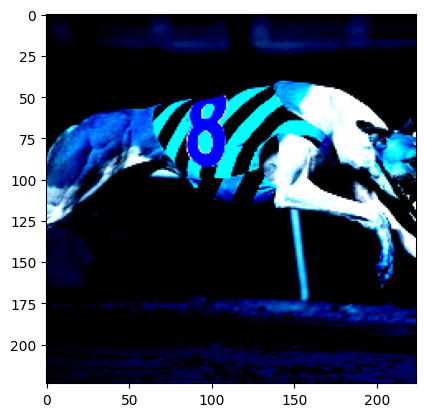

In [93]:
j = 0
plt.imshow(t[0][j].permute(1,2,0))
print("generated: ", tokenizer.decode(gen[j].detach().cpu().tolist()))
print("\nactual: ", t[1][j])

In [80]:
# gen_text = gen.detach().cpu()
# gen_text[].tolist()
# # decode(gen.detach().cpu()[3])

In [81]:
# tokenizer.decode(gen[3])

In [48]:
vlm.load_state_dict(torch.load("vlm-epoch5/model-10-04-2025.pt"))

<All keys matched successfully>

In [64]:
import datasets
ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017", data_dir="./dummy_data/")

README.md:   0%|          | 0.00/781 [00:00<?, ?B/s]

coco_dataset_script.py:   0%|          | 0.00/8.43k [00:00<?, ?B/s]

The repository for ydshieh/coco_dataset_script contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ydshieh/coco_dataset_script.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Repo card metadata block was not found. Setting CardData to empty.


train2017.zip:   0%|          | 0.00/3.59M [00:00<?, ?B/s]

val2017.zip:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

test2017.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

annotations_trainval2017.zip:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

image_info_test2017.zip:   0%|          | 0.00/3.68k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [68]:
len(ds["train"])

80

In [53]:
mod = torch.load('vlm-epoch5/model-12-04-2025.pth', weights_only=False)

In [54]:
start_token = tokenizer.encode("[START]").ids
start = torch.tensor(start_token, dtype=torch.long).unsqueeze(0).repeat(10, 1).to(device)

In [56]:
gen = mod.generate(t[0].to(device), start, 10, top_p=0.4, top_k=2000)

In [57]:
gen

tensor([[   2, 1234,  594, 2352, 3705, 2091,  237, 1833,  879, 2303, 3399],
        [   2,  278, 1968, 1968, 2086, 2187, 3280, 1968,  233,  684, 1570],
        [   2, 1676, 3431,  338, 2790, 2409, 2803, 3807,   78,  952,  613],
        [   2,  736,  518, 1572, 1498,  547, 2239,  692, 1798,  939,   74],
        [   2,  465, 3239,   13,   13, 1435, 1093, 1125,  354,  707, 1843],
        [   2, 2134,  175,  717,  465,   34, 1647, 1207,  173, 2032, 1647],
        [   2,  996,  190, 1285, 2073,   73,  287,  783, 2420, 3595, 2233],
        [   2,  112, 1082, 3629, 1531,  880,  861, 2406, 2803,  731, 1999],
        [   2, 1756, 2753, 1390,  663,  663, 3274, 1172, 1640, 1640,  103],
        [   2, 2114,  173,  581,  896, 3489, 2949, 1783, 1974,  563, 3407]],
       device='cuda:0')

generated:  ##cross descending.. chairs stru ce bike towards empty

actual:  [START] a man in white is playing a black accordion . [END]


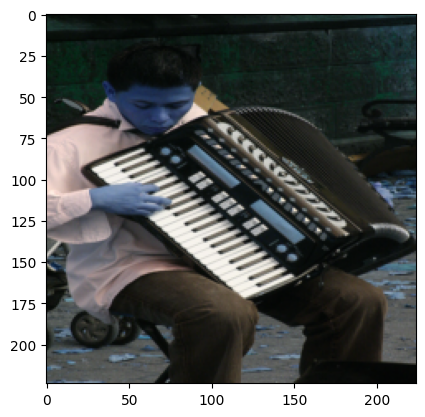

In [61]:
j = 4
plt.imshow(t[0][j].permute(1,2,0))
print("generated: ", tokenizer.decode(gen[j].detach().cpu().tolist()))
print("\nactual: ", t[1][j])